In [1]:
import csv
import matplotlib.pyplot as plt
import matplotlib
import os

In [2]:
def get_total_size(path, n_files):
    filenames = sorted(os.listdir(path))[:n_files]
    total_size = sum([os.path.getsize(path + filename) for filename in filenames])
    return total_size / (2**30)

def col_average(data):
    n_rows = len(data)
    n_cols = len(data[0])
    return [sum([data[i][j] for i in range(1, n_rows)]) / (n_rows - 1) for j in range(n_cols)]

def col_standard_deviation(data):
    n_rows = len(data)
    n_cols = len(data[0])
    mean = col_average(data)
    return [(sum([(data[i][j] - mean[j])**2 for i in range(1, n_rows)]) / (n_rows - 1))**0.5 for j in range(n_cols)]

def get_num_entries(path, n_files):
    filenames = sorted(os.listdir(path))
    num_entries = sum([uproot.open(path + filenames[i] + ":rootuple/CandidateTree").num_entries for i in range(n_files)])
    return num_entries

In [3]:
path = "../data/128_files/"

In [12]:
def plot(path, title, xlabel, ylabel, *args, plot_type=None, log_scale=False, log_base=10):
    data = []
    for i in range(0, len(args), 2):
        with open(args[i], "r") as f:
            data.append([[float(a) for a in row] for row in csv.reader(f)])
       
    for i in range(len(data)):
        if "size" in args[0]:
            for j in range(len(data[i])):
                data[i][j] = data[i][j][1:]
            data[i][0] = [get_total_size(path, int(n_files)) for n_files in data[i][0]]
        else:
            data[i][0][0] = 1
            
    plt.figure(figsize = (20, 10))
    plt.title(title, fontsize=32)
    plt.xlabel(xlabel, fontsize=24)
    plt.ylabel(ylabel, fontsize=24)
    plt.xticks(range(0, 129, 8), fontsize=20)
#     plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    if log_scale: plt.yscale("log", base=log_base)
    
    if plot_type == "speed-up":
        for j in range(len(data)):
            plt.plot(data[j][0], [col_average(data[j])[0] / runtime for runtime in col_average(data[j])], marker="o", label=args[2 * j + 1])
    elif plot_type == "ratio" and len(args) == 4:
        shorter_length = min(len(data[0][0]), len(data[1][0]))
        plt.plot(data[0][0][:shorter_length], [col_average(data[0])[i] / col_average(data[1])[i] for i in range(shorter_length)], marker="o")
        plt.hlines(y=1, xmin=0, xmax=129, color='red', linestyle ='dashed')
    elif plot_type == "errorbars":
        for j in range(len(data)):
            plt.errorbar(data[j][0], col_average(data[j]), yerr=col_standard_deviation(data[j]), fmt="-", ecolor="black", capsize=4, label=args[2 * j + 1])
    else:    
        for j in range(len(data)):
            plt.plot(data[j][0], col_average(data[j]), marker="o", label=args[2 * j + 1])
    
    plt.legend(prop={'size': 24})
    plt.show()

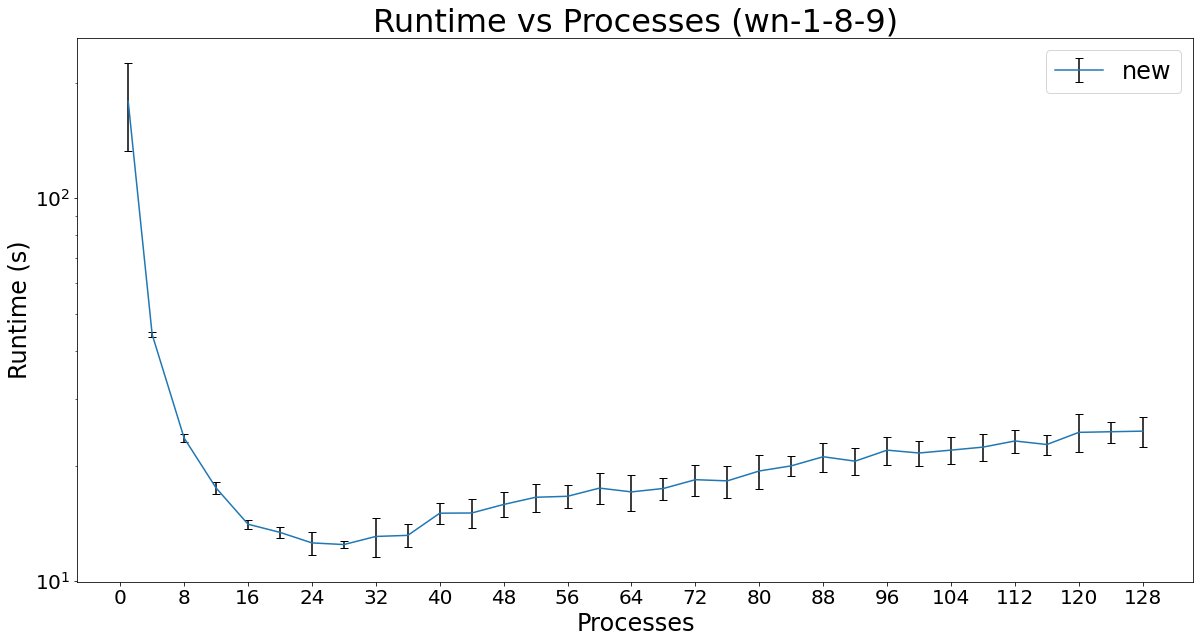

In [19]:
plot(path,
     'Runtime vs Processes (wn-1-8-9)',
     'Processes',
     'Runtime (s)',
#      "runtime_tests_uproot/128_files/wn-1-8-9_old/runtime_vs_processes_128_128_4_20.csv",
#      "old",
     "runtime_tests_uproot/128_files/wn-1-8-9/runtime_vs_processes_128_128_4_20.csv",
     "new",
#      "runtime_tests_rdf/128_files/wn-1-8-9/runtime_vs_processes_128_128_4_20.csv",
#      "rdf",
#      plot_type="speed-up",
     log_scale=True,
#      log_base=2,
     plot_type="errorbars"
    )

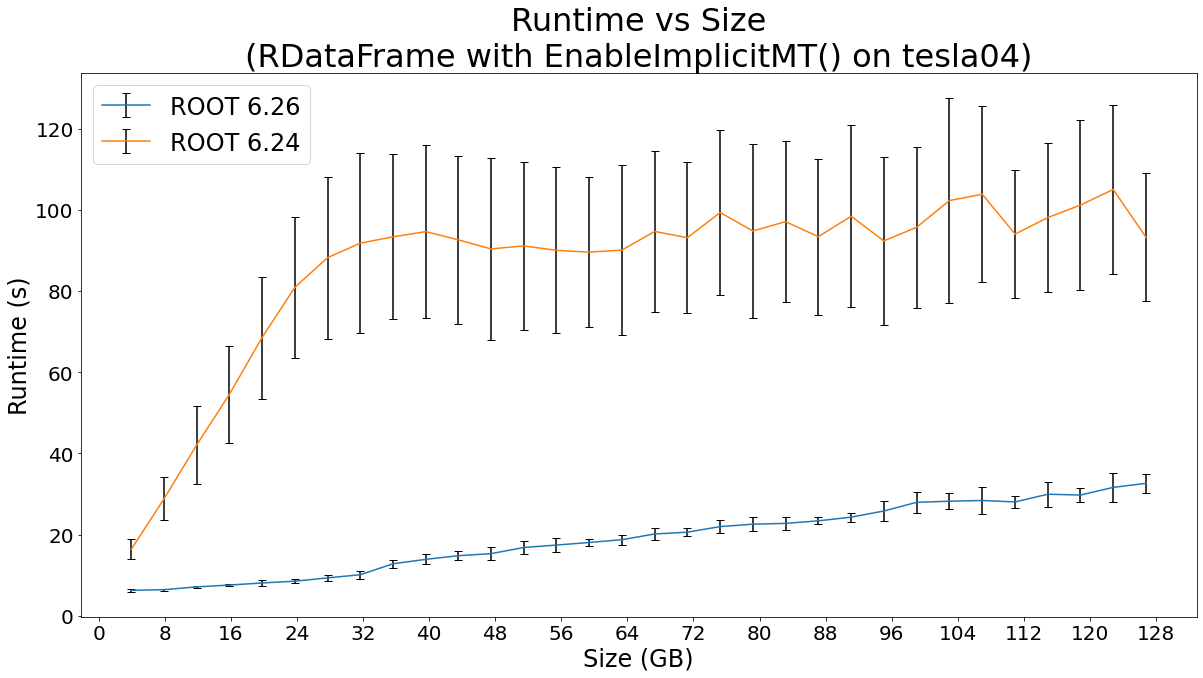

In [11]:
plot(path,
     'Runtime vs Size\n(RDataFrame with EnableImplicitMT() on tesla04)',
     'Size (GB)',
     'Runtime (s)',
     "runtime_tests_rdf/128_files/tesla04_remote/runtime_vs_size_128_4_20.csv",
     "ROOT 6.26",
     "runtime_tests_rdf/128_files/tesla04_remote_6_24/runtime_vs_size_128_4_20.csv",
     "ROOT 6.24",
#      log_scale=True,
#      log_base=2,
     plot_type="errorbars"
    )

In [18]:
import scipy

In [19]:
def linear(x, a, b):
    return a * x + b

In [20]:
def fit(path, csv_file):
    with open(csv_file, "r") as f:
        data = [[float(a) for a in row] for row in csv.reader(f)]
       
    if "size" in csv_file:
        for j in range(len(data)):
            data[j] = data[j][1:]
        data[0] = [get_total_size(path, int(n_files)) for n_files in data[0]]
    else:
        data[0][0] = 1
            
    return scipy.optimize.curve_fit(linear, data[0], col_average(data))


In [34]:
fit(path, "runtime_tests_rdf/128_files/wn-gpu-8-3-22/runtime_vs_size_128_4_20.csv")

(array([  6.34995173, -37.38196143]),
 array([[ 1.25399398e-03, -8.19384239e-02],
        [-8.19384239e-02,  7.03222021e+00]]))

In [22]:
0.96 * 128 + 0.3

123.17999999999999

In [26]:
0.1 * 128 + 2.6

15.4

In [27]:
123 / 15

8.2

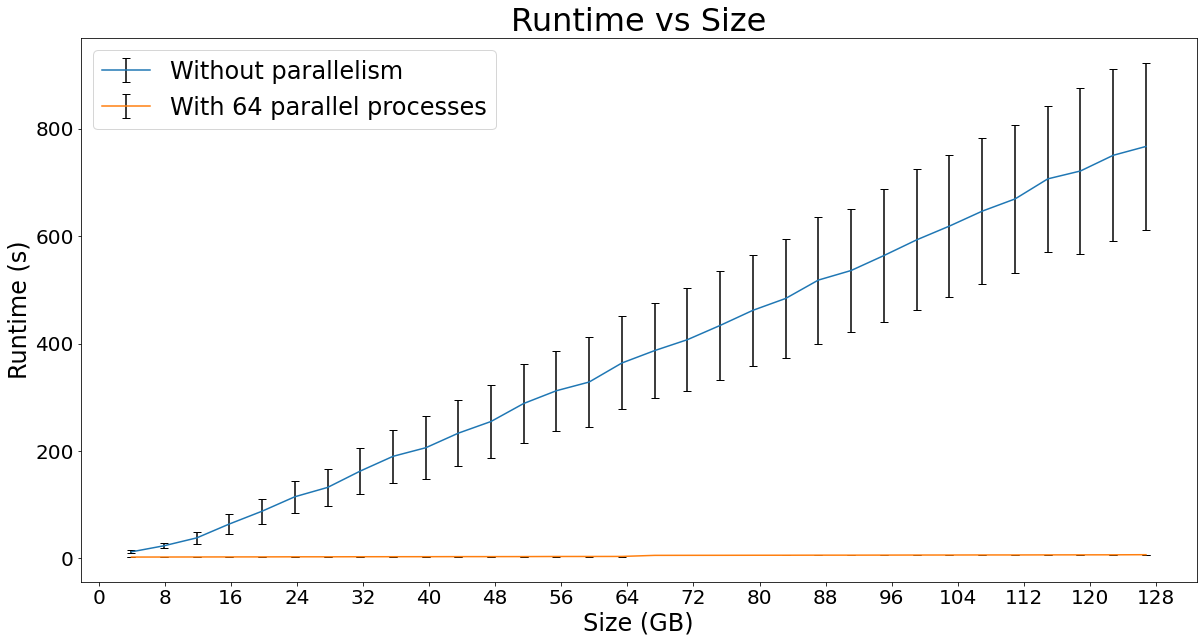

In [36]:
plot(path,
     'Runtime vs Size',
     'Size (GB)',
     'Runtime (s)',
     "runtime_tests_rdf/128_files/wn-gpu-8-3-22/runtime_vs_size_128_4_20.csv",
     "Without parallelism",
     "runtime_tests_rdf/128_files/wn-gpu-8-3-22/runtime_vs_size_mp_64_128_4_20.csv",
     "With 64 parallel processes",
     plot_type="errorbars"
    )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


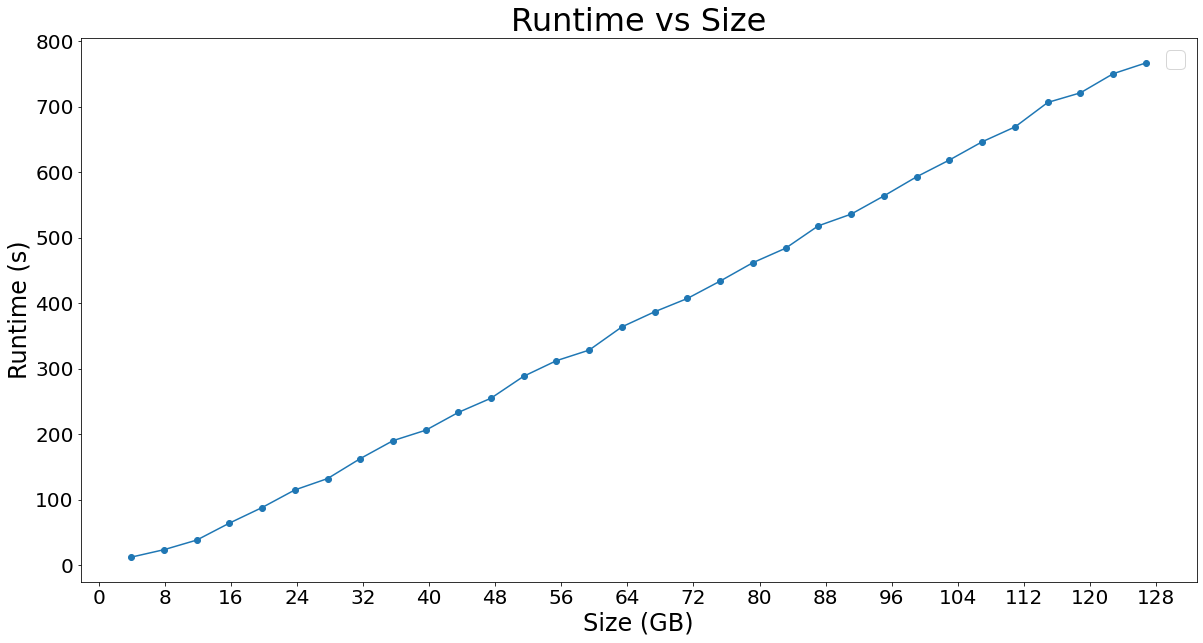

In [31]:
plot(path,
     'Runtime vs Size',
     'Size (GB)',
     'Runtime (s)',
     "runtime_tests_rdf/128_files/wn-gpu-8-3-22/runtime_vs_size_128_4_20.csv",
     "",
#      plot_type="errorbars"
    )

In [52]:
def get_data(path, csv_file):
    with open(csv_file, "r") as f:
        data = [[float(a) for a in row] for row in csv.reader(f)]
        if "size" in csv_file:
            for j in range(len(data)):
                data[j] = data[j][1:]
            data[0] = [get_total_size(path, int(n_files)) for n_files in data[0]]
        else:
            data[0][0] = 1
    return data

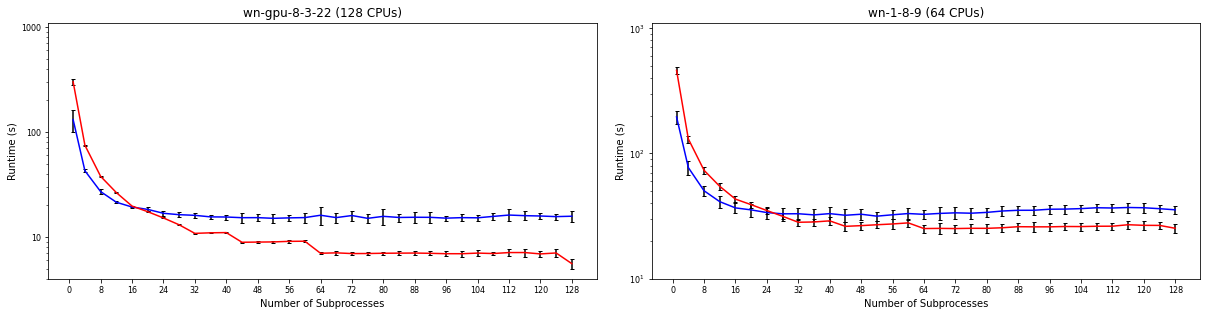

In [277]:
path = "../data/128_files/"
xlabel = "Number of Subprocesses"
ylabel = "Runtime (s)"

fig = plt.figure(figsize = (20, 10))

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.25)

wn8322_uproot = get_data(path, "runtime_tests_uproot/128_files/wn-gpu-8-3-22/runtime_vs_processes_128_128_4_20.csv")
wn8322_rdf = get_data(path, "runtime_tests_rdf/128_files/wn-gpu-8-3-22/runtime_vs_processes_128_128_4_20.csv")

wn8322_rvp = fig.add_subplot(221)

wn8322_rvp.set_title("wn-gpu-8-3-22 (128 CPUs)", fontsize=12)
wn8322_rvp.set_xlabel(xlabel, fontsize=10)
wn8322_rvp.set_ylabel(ylabel, fontsize=10)
wn8322_rvp.set_xticks(range(0, 129, 8))
wn8322_rvp.set_yscale("log", base=10)
wn8322_rvp.set_yticks([1, 10, 100, 1000], [1, 10, 100, 1000])
wn8322_rvp.set_ylim(bottom=4, top=1100)
wn8322_rvp.tick_params(labelsize=8)

wn8322_rvp.errorbar(wn8322_uproot[0], 
                    col_average(wn8322_uproot), 
                    yerr=col_standard_deviation(wn8322_uproot), 
                    fmt="-", 
                    ecolor="black",
                    color="blue",
#                     label="Uproot",
                    capsize=2)

wn8322_rvp.errorbar(wn8322_rdf[0], 
                    col_average(wn8322_rdf), 
                    yerr=col_standard_deviation(wn8322_rdf), 
                    fmt="-", 
                    ecolor="black",
                    color="red",
#                     label="RDataFrame",
                    capsize=2)

wn189_uproot = get_data(path, "runtime_tests_uproot/128_files/wn-1-8-9/runtime_vs_processes_128_128_4_20.csv")
wn189_rdf = get_data(path, "runtime_tests_rdf/128_files/wn-1-8-9/runtime_vs_processes_128_128_4_20.csv")

wn189_rvp = fig.add_subplot(222)

wn189_rvp.set_title("wn-1-8-9 (64 CPUs)", fontsize=12)
wn189_rvp.set_xlabel(xlabel, fontsize=10)
wn189_rvp.set_ylabel(ylabel, fontsize=10)
wn189_rvp.set_xticks(range(0, 129, 8))
wn189_rvp.set_yscale("log", base=10)
wn189_rvp.set_yticks([1, 10, 100, 1000], [1, 10, 100, 1000])
wn189_rvp.set_ylim(bottom=10, top=1100)
wn189_rvp.tick_params(labelsize=8)


wn189_rvp.errorbar(wn189_uproot[0], 
                    col_average(wn189_uproot), 
                    yerr=col_standard_deviation(wn189_uproot), 
                    fmt="-", 
                    ecolor="black",
                    color="blue",
                    capsize=2)

wn189_rvp.errorbar(wn189_rdf[0], 
                    col_average(wn189_rdf), 
                    yerr=col_standard_deviation(wn189_rdf), 
                    fmt="-", 
                    ecolor="black",
                    color="red",
                    capsize=2)

# tesla_local_uproot = get_data(path, "runtime_tests_uproot/128_files/tesla04_local/runtime_vs_processes_128_128_4_20.csv")
# tesla_local_rdf = get_data(path, "runtime_tests_rdf/128_files/tesla04_local/runtime_vs_processes_128_128_4_20.csv")

# tesla_local_rvp = fig.add_subplot(223)

# tesla_local_rvp.set_title("tesla04 (32 CPUs), data accessed locally", fontsize=12)
# tesla_local_rvp.set_xlabel(xlabel, fontsize=10)
# tesla_local_rvp.set_ylabel(ylabel, fontsize=10)
# tesla_local_rvp.set_xticks(range(0, 129, 8))
# tesla_local_rvp.set_yscale("log", base=10)
# tesla_local_rvp.set_yticks([1, 10, 100, 1000], [1, 10, 100, 1000])
# tesla_local_rvp.set_ylim(bottom=10, top=1100)
# tesla_local_rvp.tick_params(labelsize=8)


# tesla_local_rvp.errorbar(tesla_local_uproot[0], 
#                     col_average(tesla_local_uproot), 
#                     yerr=col_standard_deviation(tesla_local_uproot), 
#                     fmt="-", 
#                     ecolor="black", 
#                     color="blue",
#                     capsize=2)

# tesla_local_rvp.errorbar(tesla_local_rdf[0], 
#                     col_average(tesla_local_rdf), 
#                     yerr=col_standard_deviation(tesla_local_rdf), 
#                     fmt="-", 
#                     ecolor="black",
#                     color="red",
#                     capsize=2)


# tesla04_remote_uproot = get_data(path, "runtime_tests_uproot/128_files/tesla04_remote/runtime_vs_processes_128_128_4_20.csv")
# tesla04_remote_rdf = get_data(path, "runtime_tests_rdf/128_files/tesla04_remote/runtime_vs_processes_128_128_4_20.csv")

# tesla04_remote_rvp = fig.add_subplot(224)

# tesla04_remote_rvp.set_title("tesla04 (32 CPUs), data accessed remotely", fontsize=12)
# tesla04_remote_rvp.set_xlabel(xlabel, fontsize=10)
# tesla04_remote_rvp.set_ylabel(ylabel, fontsize=10)
# tesla04_remote_rvp.set_xticks(range(0, 129, 8))
# tesla04_remote_rvp.set_yscale("log", base=10)
# tesla04_remote_rvp.set_yticks([1, 10, 100, 1000], [1, 10, 100, 1000])
# tesla04_remote_rvp.set_ylim(bottom=10, top=1100)
# tesla04_remote_rvp.tick_params(labelsize=8)


# tesla04_remote_rvp.errorbar(tesla_remote_uproot[0], 
#                     col_average(tesla_remote_uproot), 
#                     yerr=col_standard_deviation(tesla_remote_uproot), 
#                     fmt="-", 
#                     ecolor="black", 
#                     color="blue",
#                     capsize=2)

# tesla04_remote_rvp.errorbar(tesla_remote_rdf[0], 
#                     col_average(tesla_remote_rdf), 
#                     yerr=col_standard_deviation(tesla_remote_rdf), 
#                     fmt="-", 
#                     ecolor="black",
#                     color="red",
#                     capsize=2)

# fig.legend()
plt.show()

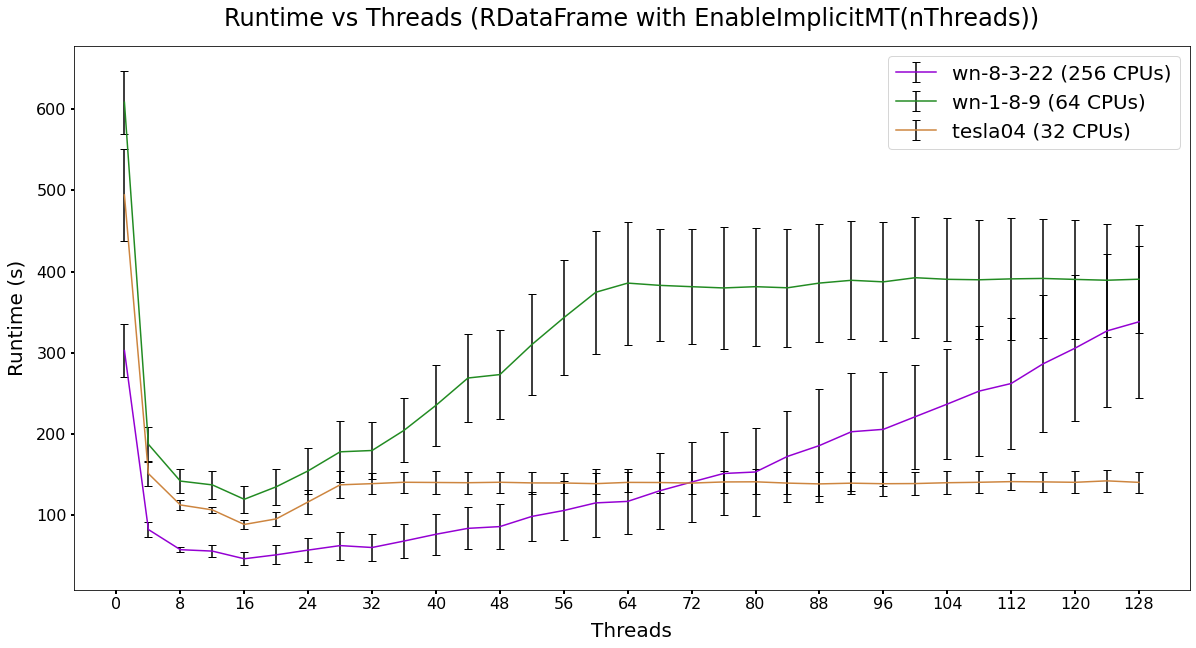

In [270]:
fig = plt.figure(figsize = (20, 10))

xlabel = "Threads"
ylabel = "Runtime (s)"

wn8322 = get_data(path, "runtime_tests_rdf/128_files/wn-gpu-8-3-22/runtime_vs_threads_128_128_4_20.csv")
wn189 = get_data(path, "runtime_tests_rdf/128_files/wn-1-8-9/runtime_vs_threads_128_128_4_20.csv")
tesla = get_data(path, "runtime_tests_rdf/128_files/tesla04_remote_6_24/runtime_vs_threads_128_128_4_20.csv")


rvp = fig.add_subplot(111)

rvp.set_title("Runtime vs Threads (RDataFrame with EnableImplicitMT(nThreads))", fontsize=24, pad=20)
rvp.set_xlabel(xlabel, fontsize=20, labelpad=10)
rvp.set_ylabel(ylabel, fontsize=20, labelpad=10)
rvp.set_xticks(range(0, 129, 8))
# wn8322_rvp.set_yscale("log", base=10)
# wn8322_rvp.set_yticks([1, 10, 100, 1000], [1, 10, 100, 1000])
# wn8322_rvp.set_ylim(bottom=10, top=1100)
rvp.tick_params(width=2, labelsize=16)

rvp.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

rvp.errorbar(wn8322[0], 
            col_average(wn8322), 
            yerr=col_standard_deviation(wn8322), 
            fmt="-", 
            ecolor="black",
            color="darkviolet",
            label="wn-8-3-22 (256 CPUs)",
            capsize=4)

rvp.errorbar(wn189[0], 
            col_average(wn189), 
            yerr=col_standard_deviation(wn189), 
            fmt="-", 
            ecolor="black",
            color="forestgreen",
            label="wn-1-8-9 (64 CPUs)",
            capsize=4)

rvp.errorbar(tesla[0], 
            col_average(tesla), 
            yerr=col_standard_deviation(tesla), 
            fmt="-", 
            ecolor="black",
            color="peru",
            label="tesla04 (32 CPUs)",
            capsize=4)

rvp.legend(fontsize=20)
plt.show()

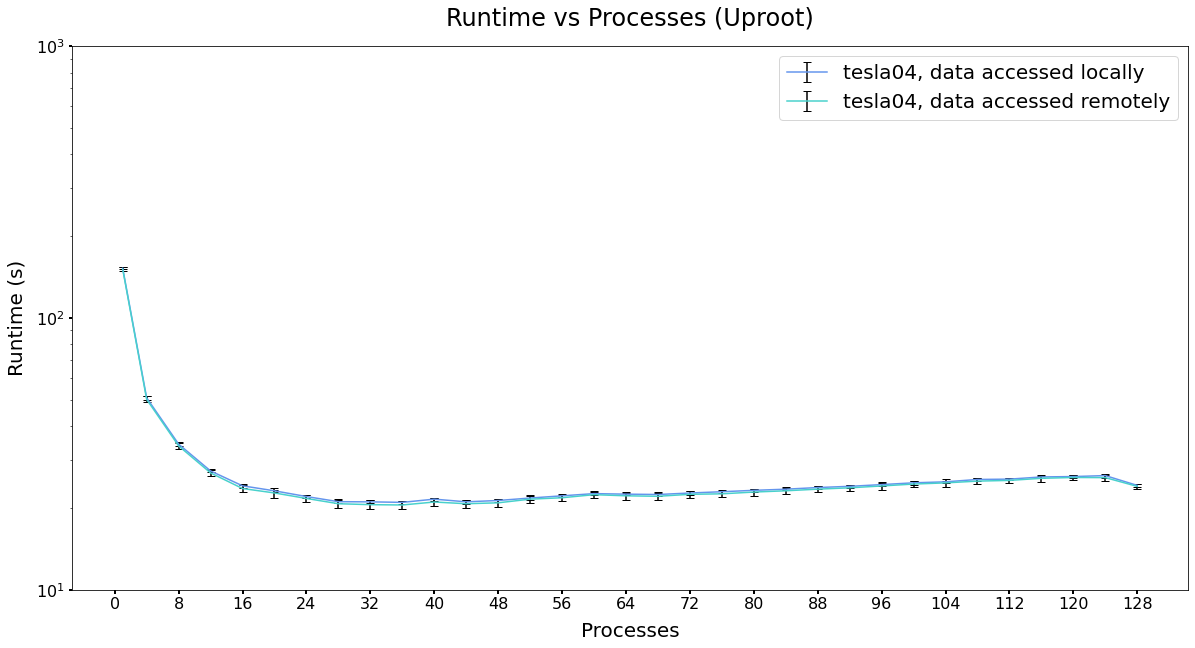

In [287]:
fig = plt.figure(figsize = (20, 10))

xlabel = "Processes"
ylabel = "Runtime (s)"
# r626 = get_data(path, "runtime_tests_rdf/128_files/tesla04_remote/runtime_vs_size_128_4_20.csv")
# r624 = get_data(path, "runtime_tests_rdf/128_files/tesla04_remote_6_24/runtime_vs_size_128_4_20.csv")
local = get_data(path, "runtime_tests_uproot/128_files/tesla04_local/runtime_vs_processes_128_128_4_20.csv")
remote = get_data(path, "runtime_tests_uproot/128_files/tesla04_remote/runtime_vs_processes_128_128_4_20.csv")

rvp = fig.add_subplot(111)

rvp.set_title("Runtime vs Processes (Uproot)", fontsize=24, pad=20)
rvp.set_xlabel(xlabel, fontsize=20, labelpad=10)
rvp.set_ylabel(ylabel, fontsize=20, labelpad=10)
rvp.set_xticks(range(0, 129, 8))
rvp.set_yscale("log", base=10)
# rvp.set_yticks([1, 10, 100, 1000], [1, 10, 100, 1000])
rvp.set_ylim(bottom=10, top=1000)
rvp.tick_params(width=2, labelsize=16)

rvp.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

rvp.errorbar(local[0], 
            col_average(local), 
            yerr=col_standard_deviation(local), 
            fmt="-", 
            ecolor="black",
            color="cornflowerblue",
            label="tesla04, data accessed locally",
            capsize=4)

rvp.errorbar(remote[0], 
            col_average(remote), 
            yerr=col_standard_deviation(remote), 
            fmt="-", 
            ecolor="black",
            color="mediumturquoise",
            label="tesla04, data accessed remotely",
            capsize=4)

rvp.legend(fontsize=20)
plt.show()

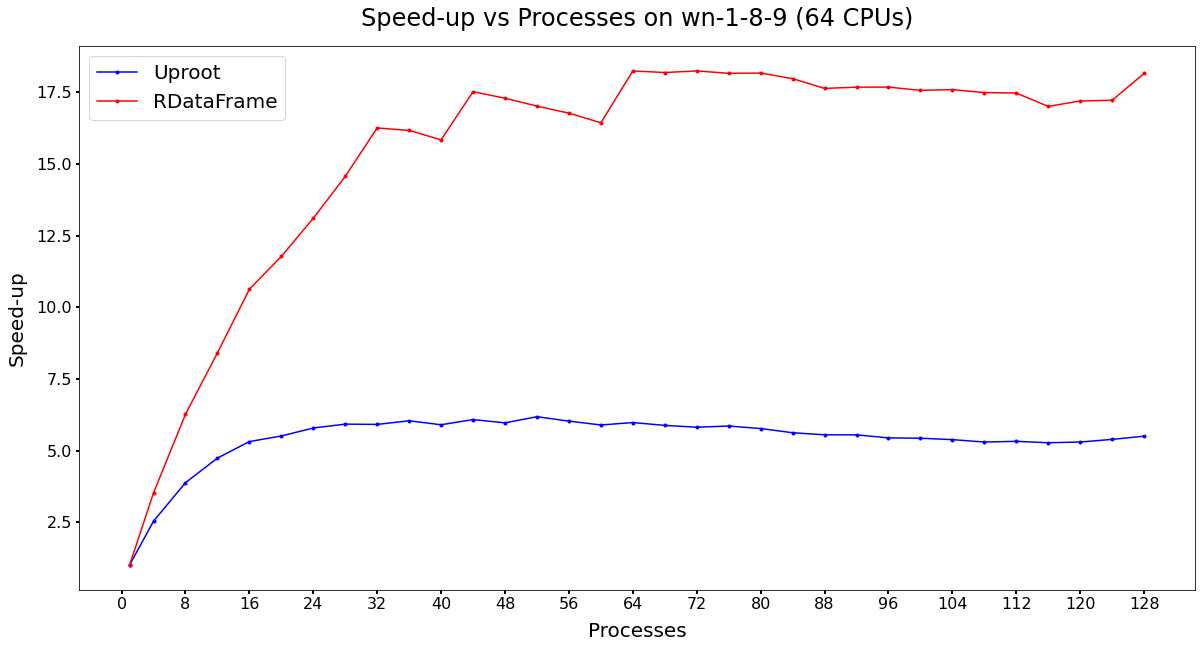

In [318]:
fig = plt.figure(figsize = (20, 10))

xlabel = "Processes"
ylabel = "Speed-up"
# r626 = get_data(path, "runtime_tests_rdf/128_files/tesla04_remote/runtime_vs_size_128_4_20.csv")
# r624 = get_data(path, "runtime_tests_rdf/128_files/tesla04_remote_6_24/runtime_vs_size_128_4_20.csv")
uproot = get_data(path, "runtime_tests_uproot/128_files/wn-1-8-9/runtime_vs_processes_128_128_4_20.csv")
rdf = get_data(path, "runtime_tests_rdf/128_files/wn-1-8-9/runtime_vs_processes_128_128_4_20.csv")

rvp = fig.add_subplot(111)

rvp.set_title("Speed-up vs Processes on wn-1-8-9 (64 CPUs)", fontsize=24, pad=20)
rvp.set_xlabel(xlabel, fontsize=20, labelpad=10)
rvp.set_ylabel(ylabel, fontsize=20, labelpad=10)
rvp.set_xticks(range(0, 129, 8))
# rvp.set_yscale("log", base=10)
# rvp.set_yticks([1, 10, 100, 1000], [1, 10, 100, 1000])
# rvp.set_ylim(bottom=10, top=1000)
rvp.tick_params(width=2, labelsize=16)

rvp.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

rvp.plot(uproot[0], 
         [col_average(uproot)[0] / runtime for runtime in col_average(uproot)], 
         marker=".",
         label="Uproot",
         color="blue")

rvp.plot(rdf[0], 
         [col_average(rdf)[0] / runtime for runtime in col_average(rdf)], 
         marker=".",
         label="RDataFrame",
         color="red")

# rvp.errorbar(uproot[0], 
#             col_average(uproot), 
#             yerr=col_standard_deviation(uproot), 
#             fmt="-", 
#             ecolor="black",
#             color="blue",
#             label="Uproot",
#             capsize=4)

# rvp.errorbar(rdf[0], 
#             col_average(rdf), 
#             yerr=col_standard_deviation(rdf), 
#             fmt="-", 
#             ecolor="black",
#             color="red",
#             label="RDataFrame",
#             capsize=4)

rvp.legend(fontsize=20)
plt.show()

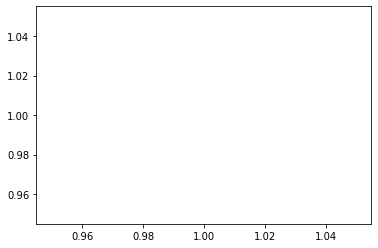

<Figure size 1440x720 with 0 Axes>

In [227]:
import numpy as np
x = [1]
y = [1]
y1 = [1]
y2 = [1]
y3 = [1]
fig = plt.figure("Line plot")
legendFig = plt.figure("Legend plot", figsize = (20, 10))
ax = fig.add_subplot(111)
line1, = ax.plot(x, y, lw=10, c="blue")
line2, = ax.plot(x, y1, lw=10, c="red")
line3, = ax.plot(x, y2, lw=10, c="deepskyblue")
line4, = ax.plot(x, y3, lw=10, c="coral")
legendFig.legend([line1, line2, line3, line4], 
                 ["Uproot (64 Subprocesses)", 
                  "RDataFrame (64 Subprocesses)", 
                  "Uproot (32 Subprocesses)", 
                  "RDataFrame (32 Subprocesses)"], 
                 loc='center', fontsize=48)
legendFig.savefig('legend.png')

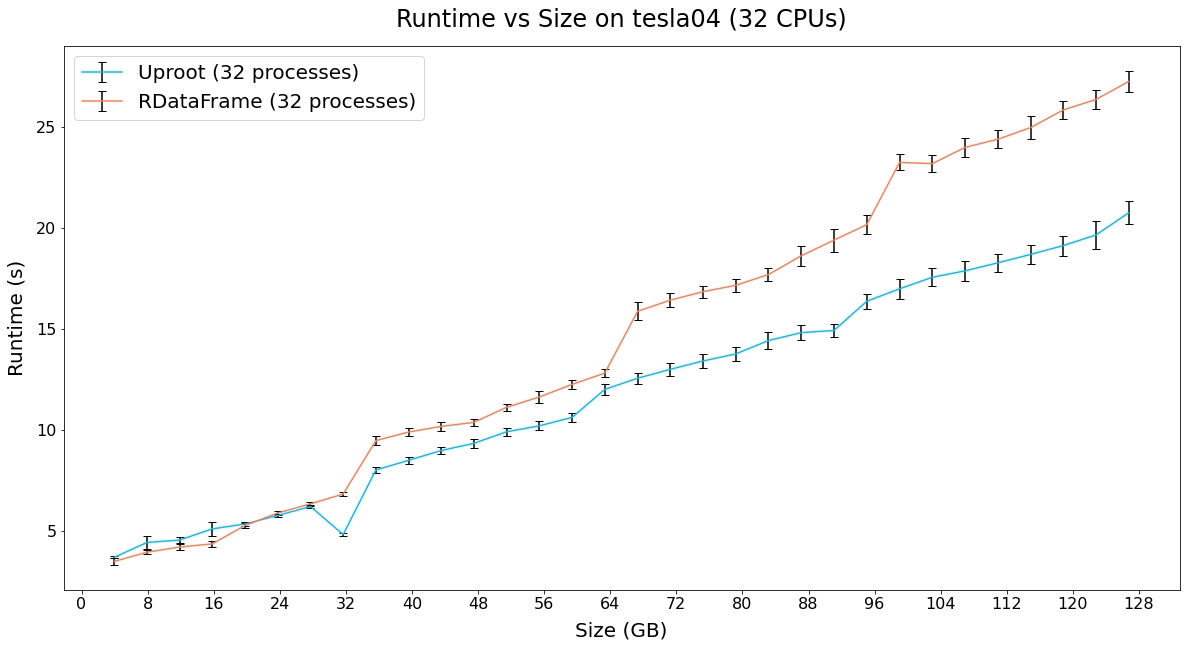

In [308]:
path = "../data/128_files/"
xlabel = "Size (GB)"
ylabel = "Runtime (s)"

fig = plt.figure(figsize = (20, 10))

# plt.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.1,
#                     hspace=0.25)

# wn8322_uproot64 = get_data(path, "runtime_tests_uproot/128_files/wn-gpu-8-3-22/runtime_vs_size_mp_64_128_4_20.csv")
# wn8322_rdf64 = get_data(path, "runtime_tests_rdf/128_files/wn-gpu-8-3-22/runtime_vs_size_mp_64_128_4_20.csv")
wn8322_uproot32 = get_data(path, "runtime_tests_uproot/128_files/tesla04_remote/runtime_vs_size_mp_32_128_4_20.csv")
wn8322_rdf32 = get_data(path, "runtime_tests_rdf/128_files/tesla04_remote/runtime_vs_size_mp_32_128_4_20.csv")

wn8322_rvp = fig.add_subplot(111)

wn8322_rvp.set_title("Runtime vs Size on tesla04 (32 CPUs)", fontsize=24, pad=20)
wn8322_rvp.set_xlabel(xlabel, fontsize=20, labelpad=10)
wn8322_rvp.set_ylabel(ylabel, fontsize=20, labelpad=10)
wn8322_rvp.set_xticks(range(0, 129, 8))
# wn8322_rvp.set_yscale("log", base=10)
# wn8322_rvp.set_yticks([1, 10, 100, 1000], [1, 10, 100, 1000])
# wn8322_rvp.set_ylim(bottom=4, top=1100)
wn8322_rvp.tick_params(labelsize=16)

# wn8322_rvp.errorbar(wn8322_uproot64[0], 
#                     col_average(wn8322_uproot64), 
#                     yerr=col_standard_deviation(wn8322_uproot64), 
#                     fmt="-", 
#                     ecolor="black",
#                     color="blue",
#                     label="Uproot (64 processes)",
#                     capsize=4)

wn8322_rvp.errorbar(wn8322_uproot32[0], 
                    col_average(wn8322_uproot32), 
                    yerr=col_standard_deviation(wn8322_uproot32), 
                    fmt="-", 
                    ecolor="black",
                    color="deepskyblue",
                    label="Uproot (32 processes)",
                    capsize=4)

# wn8322_rvp.errorbar(wn8322_rdf64[0], 
#                     col_average(wn8322_rdf64), 
#                     yerr=col_standard_deviation(wn8322_rdf64), 
#                     fmt="-", 
#                     ecolor="black",
#                     color="red",
#                     label="RDataFrame (64 processes)",
#                     capsize=4)

wn8322_rvp.errorbar(wn8322_rdf32[0], 
                    col_average(wn8322_rdf32), 
                    yerr=col_standard_deviation(wn8322_rdf32), 
                    fmt="-", 
                    ecolor="black",
                    color="coral",
                    label="RDataFrame (32 processes)",
                    capsize=4)

# wn189_uproot64 = get_data(path, "runtime_tests_uproot/128_files/wn-1-8-9/runtime_vs_size_mp_64_128_4_20.csv")
# wn189_rdf64 = get_data(path, "runtime_tests_rdf/128_files/wn-1-8-9/runtime_vs_size_mp_64_128_4_20.csv")
# wn189_uproot32 = get_data(path, "runtime_tests_uproot/128_files/wn-1-8-9/runtime_vs_size_mp_32_128_4_20.csv")
# wn189_rdf32 = get_data(path, "runtime_tests_rdf/128_files/wn-1-8-9/runtime_vs_size_mp_32_128_4_20.csv")

# wn189_rvp = fig.add_subplot(222)

# wn189_rvp.set_title("wn-1-8-9 (64 CPUs)", fontsize=12)
# wn189_rvp.set_xlabel(xlabel, fontsize=10)
# wn189_rvp.set_ylabel(ylabel, fontsize=10)
# wn189_rvp.set_xticks(range(0, 129, 8))
# # wn189_rvp.set_yscale("log", base=10)
# # wn189_rvp.set_yticks([1, 10, 100, 1000], [1, 10, 100, 1000])
# # wn189_rvp.set_ylim(bottom=10, top=1100)
# wn189_rvp.tick_params(labelsize=8)


# wn189_rvp.errorbar(wn189_uproot64[0], 
#                     col_average(wn189_uproot64), 
#                     yerr=col_standard_deviation(wn189_uproot64), 
#                     fmt="-", 
#                     ecolor="black",
#                     color="blue",
#                     capsize=2)

# wn189_rvp.errorbar(wn189_uproot32[0], 
#                     col_average(wn189_uproot32), 
#                     yerr=col_standard_deviation(wn189_uproot32), 
#                     fmt="-", 
#                     ecolor="black",
#                     color="deepskyblue",
#                     capsize=2)

# wn189_rvp.errorbar(wn189_rdf64[0], 
#                     col_average(wn189_rdf64), 
#                     yerr=col_standard_deviation(wn189_rdf64), 
#                     fmt="-", 
#                     ecolor="black",
#                     color="red",
#                     capsize=2)

# wn189_rvp.errorbar(wn189_rdf32[0], 
#                     col_average(wn189_rdf32), 
#                     yerr=col_standard_deviation(wn189_rdf32), 
#                     fmt="-", 
#                     ecolor="black",
#                     color="coral",
#                     capsize=2)

plt.legend(fontsize=20)
plt.show()

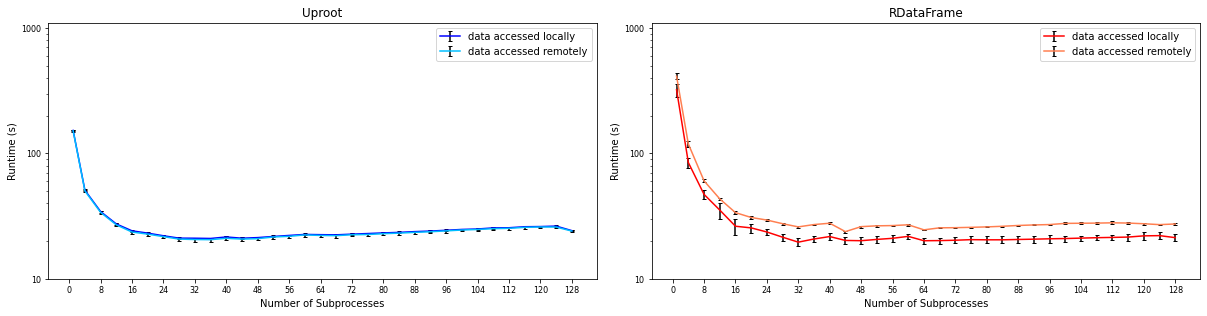

In [234]:
path = "../data/128_files/"
xlabel = "Number of Subprocesses"
ylabel = "Runtime (s)"

fig = plt.figure(figsize = (20, 10))

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.25)


tesla_local_uproot = get_data(path, "runtime_tests_uproot/128_files/tesla04_local/runtime_vs_processes_128_128_4_20.csv")
tesla_remote_uproot = get_data(path, "runtime_tests_uproot/128_files/tesla04_remote/runtime_vs_processes_128_128_4_20.csv")

tesla_uproot_rvp = fig.add_subplot(221)

tesla_uproot_rvp.set_title("Uproot", fontsize=12)
tesla_uproot_rvp.set_xlabel(xlabel, fontsize=10)
tesla_uproot_rvp.set_ylabel(ylabel, fontsize=10)
tesla_uproot_rvp.set_xticks(range(0, 129, 8))
tesla_uproot_rvp.set_yscale("log", base=10)
tesla_uproot_rvp.set_yticks([1, 10, 100, 1000], [1, 10, 100, 1000])
tesla_uproot_rvp.set_ylim(bottom=10, top=1100)
tesla_uproot_rvp.tick_params(labelsize=8)


tesla_uproot_rvp.errorbar(tesla_local_uproot[0], 
                    col_average(tesla_local_uproot), 
                    yerr=col_standard_deviation(tesla_local_uproot), 
                    fmt="-", 
                    ecolor="black", 
                    color="blue",
                    label="data accessed locally",
                    capsize=2)


tesla_uproot_rvp.errorbar(tesla_remote_uproot[0], 
                    col_average(tesla_remote_uproot), 
                    yerr=col_standard_deviation(tesla_remote_uproot), 
                    fmt="-", 
                    ecolor="black", 
                    color="deepskyblue",
                    label="data accessed remotely",
                    capsize=2)

tesla_uproot_rvp.legend()

tesla_local_rdf = get_data(path, "runtime_tests_rdf/128_files/tesla04_local/runtime_vs_processes_128_128_4_20.csv")
tesla_remote_rdf = get_data(path, "runtime_tests_rdf/128_files/tesla04_remote/runtime_vs_processes_128_128_4_20.csv")

tesla_rdf_rvp = fig.add_subplot(222)

tesla_rdf_rvp.set_title("RDataFrame", fontsize=12)
tesla_rdf_rvp.set_xlabel(xlabel, fontsize=10)
tesla_rdf_rvp.set_ylabel(ylabel, fontsize=10)
tesla_rdf_rvp.set_xticks(range(0, 129, 8))
tesla_rdf_rvp.set_yscale("log", base=10)
tesla_rdf_rvp.set_yticks([1, 10, 100, 1000], [1, 10, 100, 1000])
tesla_rdf_rvp.set_ylim(bottom=10, top=1100)
tesla_rdf_rvp.tick_params(labelsize=8)


tesla_rdf_rvp.errorbar(tesla_local_rdf[0], 
                    col_average(tesla_local_rdf), 
                    yerr=col_standard_deviation(tesla_local_rdf), 
                    fmt="-", 
                    ecolor="black",
                    color="red",
                    label="data accessed locally",
                    capsize=2)

tesla_rdf_rvp.errorbar(tesla_remote_rdf[0], 
                    col_average(tesla_remote_rdf), 
                    yerr=col_standard_deviation(tesla_remote_rdf), 
                    fmt="-", 
                    ecolor="black",
                    color="coral",
                    label="data accessed remotely",
                    capsize=2)

tesla_rdf_rvp.legend()

plt.show()

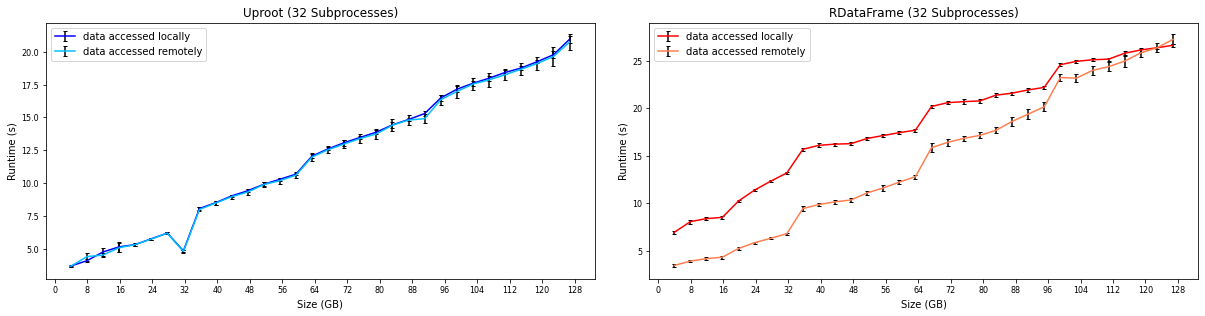

In [236]:
path = "../data/128_files/"
xlabel = "Size (GB)"
ylabel = "Runtime (s)"

fig = plt.figure(figsize = (20, 10))

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.25)


tesla_local_uproot = get_data(path, "runtime_tests_uproot/128_files/tesla04_local/runtime_vs_size_mp_32_128_4_20.csv")
tesla_remote_uproot = get_data(path, "runtime_tests_uproot/128_files/tesla04_remote/runtime_vs_size_mp_32_128_4_20.csv")

tesla_uproot_rvp = fig.add_subplot(221)

tesla_uproot_rvp.set_title("Uproot (32 Subprocesses)", fontsize=12)
tesla_uproot_rvp.set_xlabel(xlabel, fontsize=10)
tesla_uproot_rvp.set_ylabel(ylabel, fontsize=10)
tesla_uproot_rvp.set_xticks(range(0, 129, 8))
# tesla_uproot_rvp.set_yscale("log", base=10)
# tesla_uproot_rvp.set_yticks([1, 10, 100, 1000], [1, 10, 100, 1000])
# tesla_uproot_rvp.set_ylim(bottom=10, top=1100)
tesla_uproot_rvp.tick_params(labelsize=8)


tesla_uproot_rvp.errorbar(tesla_local_uproot[0], 
                    col_average(tesla_local_uproot), 
                    yerr=col_standard_deviation(tesla_local_uproot), 
                    fmt="-", 
                    ecolor="black", 
                    color="blue",
                    label="data accessed locally",
                    capsize=2)


tesla_uproot_rvp.errorbar(tesla_remote_uproot[0], 
                    col_average(tesla_remote_uproot), 
                    yerr=col_standard_deviation(tesla_remote_uproot), 
                    fmt="-", 
                    ecolor="black", 
                    color="deepskyblue",
                    label="data accessed remotely",
                    capsize=2)

tesla_uproot_rvp.legend()

tesla_local_rdf = get_data(path, "runtime_tests_rdf/128_files/tesla04_local/runtime_vs_size_mp_32_128_4_20.csv")
tesla_remote_rdf = get_data(path, "runtime_tests_rdf/128_files/tesla04_remote/runtime_vs_size_mp_32_128_4_20.csv")

tesla_rdf_rvp = fig.add_subplot(222)

tesla_rdf_rvp.set_title("RDataFrame (32 Subprocesses)", fontsize=12)
tesla_rdf_rvp.set_xlabel(xlabel, fontsize=10)
tesla_rdf_rvp.set_ylabel(ylabel, fontsize=10)
tesla_rdf_rvp.set_xticks(range(0, 129, 8))
# tesla_rdf_rvp.set_yscale("log", base=10)
# tesla_rdf_rvp.set_yticks([1, 10, 100, 1000], [1, 10, 100, 1000])
# tesla_rdf_rvp.set_ylim(bottom=10, top=1100)
tesla_rdf_rvp.tick_params(labelsize=8)


tesla_rdf_rvp.errorbar(tesla_local_rdf[0], 
                    col_average(tesla_local_rdf), 
                    yerr=col_standard_deviation(tesla_local_rdf), 
                    fmt="-", 
                    ecolor="black",
                    color="red",
                    label="data accessed locally",
                    capsize=2)

tesla_rdf_rvp.errorbar(tesla_remote_rdf[0], 
                    col_average(tesla_remote_rdf), 
                    yerr=col_standard_deviation(tesla_remote_rdf), 
                    fmt="-", 
                    ecolor="black",
                    color="coral",
                    label="data accessed remotely",
                    capsize=2)

tesla_rdf_rvp.legend()

plt.show()